In [1]:
import numpy as np
import pandas as pd
import pathlib

data_path = pathlib.Path("./data/")

from src.utils import *

import bokeh.plotting as bkp
import bokeh.models as bkm
import bokeh.layouts as bkl
from bokeh.palettes import d3
from bokeh.resources import CDN
from bokeh.embed import file_html, components
bkp.output_notebook()

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import f, t
from scipy.optimize import minimize

from tqdm import tqdm
import datetime

%load_ext autoreload
%autoreload 2

Loading BokehJS ...

# Get data

In [2]:
! rm -rf full_data.csv
! wget https://covid.ourworldindata.org/data/ecdc/full_data.csv
! mv full_data.csv data/ecdc_full_data.csv

--2020-03-26 08:55:20--  https://covid.ourworldindata.org/data/ecdc/full_data.csv
Résolution de covid.ourworldindata.org (covid.ourworldindata.org)… 142.93.108.123, 2a03:b0c0:3:e0::32e:b001
Connexion à covid.ourworldindata.org (covid.ourworldindata.org)|142.93.108.123|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 198087 (193K) [text/csv]
Sauvegarde en : « full_data.csv »

full_data.csv       100%[===================>] 193,44K   585KB/s    ds 0,3s    

2020-03-26 08:55:21 (585 KB/s) — « full_data.csv » sauvegardé [198087/198087]



In [3]:
data = pd.read_csv(data_path / "ecdc_full_data.csv")
data = data.rename(columns={"Total confirmed cases of COVID-19" : "total_cases"})
data['date'] = data.date.apply(pd.to_datetime)
data['date_str'] = data.date.apply(lambda x: x.strftime('%d/%m/%Y'))
data = data_china_smoothing(data, n_days_smoothing=6, n_cases_true=5000)
data.head(1)

,date,location,new_cases,new_deaths,total_cases,total_deaths,date_str
0,2019-12-31,Afghanistan,0,0,0,0,31/12/2019


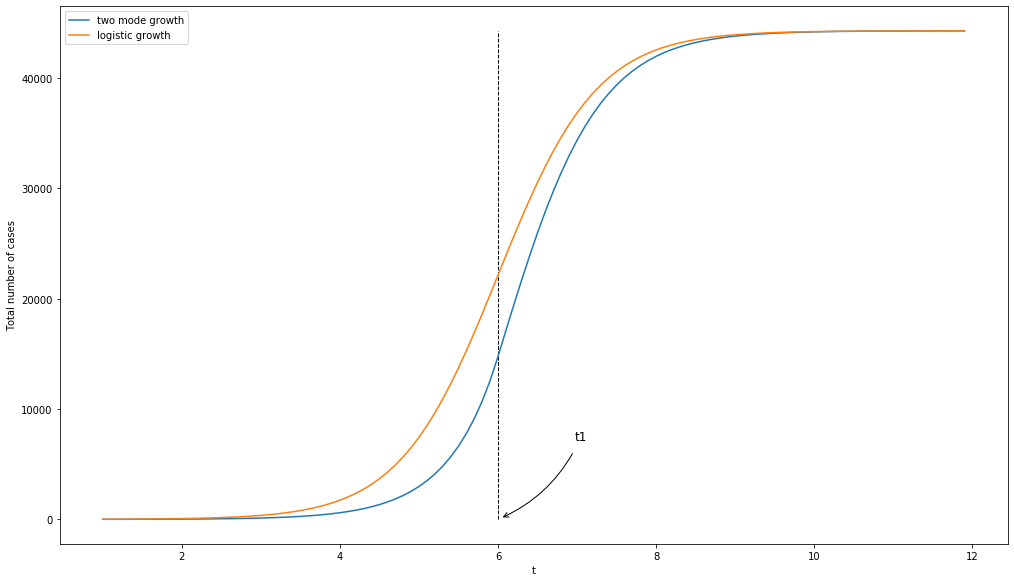

In [98]:
t = np.arange(1, 12, 0.1)
ind_containment = 50
t1 = t[ind_containment]
non_containment = np.zeros(ind_containment)
containment = np.ones(t.shape[0] - ind_containment)
y = np.hstack((non_containment, containment))

x0 = 6
r1 = 1.6
r2 = 1.6


K = r1/r2 * np.exp(r1*t1) * (1 / sigmoid(t1, x0, 1, r2) * 1 / (1 - sigmoid(t1, x0, 1, r2)))
a = np.exp(r1*t1) - K * (1 / (1 + np.exp(-r2*(t1-x0))))

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot([t1, t1], [0, max(sigmoid(t, x0, K + a, r1))], 'k--', linewidth=1)
ax.plot(t, two_mode_growth(t, x0, K, r1, r2, y, t1), label='two mode growth')

ax.annotate('t1', xy=(t1, 0),  xycoords='data',
            xytext=(0.55, 0.2), textcoords='axes fraction', size=12, weight=500,
            horizontalalignment='center', verticalalignment='center',
            arrowprops=dict(arrowstyle="->",
                            color="k",
                            patchB=None,
                            shrinkA=10,
                            shrinkB=5,
                            connectionstyle="arc3,rad=-0.2",
            ))

ax.plot(t, sigmoid(t, x0, K + a, r1), label='logistic growth')
plt.legend()
plt.tight_layout()
plt.xlabel('t')
plt.ylabel('Total number of cases')
plt.savefig("img/difs-two-models.png", dpi=200, bbox_inches='tight')
plt.show()

* Compute predictions

In [8]:
df_all_prediction = pd.DataFrame()
countries = ["France"]

for country in tqdm(countries, position=0, leave=True):
    print("fit model for " + country + " data")
    df = get_country_and_min_count(data, country)
    
    fitted_sigmoid_df, paramters_values_sigmoid = compute_moving_predictions(df, n_prediction=90, n_bootstrap=3, 
                                                                             min_data=df.shape[0]-5, step=1, loss='MSE', linear_proba=True)
    fitted_sigmoid_df["location"] = np.repeat(country, repeats=fitted_sigmoid_df.shape[0])
    
    df_all_prediction = pd.concat([df_all_prediction, fitted_sigmoid_df])
    
df_all_prediction

  0%|          | 0/1 [00:00<?, ?it/s]

fit model for France data


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


,date,date_str,25%,median,75%,derivative,median_display,date_end_train,location
0,2020-02-27,27/02/2020,60.545325,69.990137,74.361261,17.817010,69,2020-03-20,France
1,2020-02-28,28/02/2020,78.089668,90.271322,95.909076,22.961202,90,2020-03-20,France
2,2020-02-29,29/02/2020,100.694152,116.402008,123.671714,29.576708,116,2020-03-20,France
3,2020-03-01,01/03/2020,129.802533,150.051173,159.422384,38.075142,150,2020-03-20,France
4,2020-03-02,02/03/2020,167.260151,193.352019,205.427516,48.977209,193,2020-03-20,France
...,...,...,...,...,...,...,...,...,...
84,2020-05-21,21/05/2020,52832.337189,54849.537835,56336.638203,0.131977,"54,849",2020-03-25,France
85,2020-05-22,22/05/2020,52832.452052,54849.657084,56336.760685,0.107367,"54,849",2020-03-25,France
86,2020-05-23,23/05/2020,52832.545496,54849.754096,56336.860328,0.087345,"54,849",2020-03-25,France
87,2020-05-24,24/05/2020,52832.621515,54849.833018,56336.941389,0.071058,"54,849",2020-03-25,France


# Plot data

In [9]:
COLORS = d3['Category10'][10]

tooltips = f"""
        <div>
            <p>
                <span style="font-size: 12px; color: black;font-family:century gothic;">Nombre de cas : </span>
                <span style="font-size: 12px; color: {COLORS[0]}; font-weight: bold;font-family:century gothic;">@total_cases</span>
            <br> 
                <span style="font-size: 12px; color: black;font-family:century gothic;">Nombre de nouveaux cas : </span>
                <span style="font-size: 12px; color: {COLORS[1]}; font-weight: bold;font-family:century gothic;">@new_cases</span>
            <br> 
                <span style="font-size: 12px; color: black;font-family:century gothic;">Nombre de deces : </span>
                <span style="font-size: 12px; color: {COLORS[3]}; font-weight: bold;font-family:century gothic;">@total_deaths</span>
            <br> 
                <span style="font-size: 12px; color: black;font-family:century gothic;">Nombre nouveaux deces : </span>
                <span style="font-size: 12px; color: {COLORS[5]}; font-weight: bold;font-family:century gothic;">@new_deaths</span>
            <br> 
                <span style="font-size: 12px; color: black;font-family:century gothic;">Date : </span>
                <span style="font-size: 12px; color: black; font-weight: bold;font-family:century gothic;">""" + """@date_str</span>
            </p>
        </div>
    """

tooltips_predictions = f"""
        <div>
            <p>
                <span style="font-size: 12px; color: black;font-family:century gothic;">Prédiction nombre de cas : </span>
                <span style="font-size: 12px; color: {COLORS[0]}; font-weight: bold;font-family:century gothic;">@median_display</span>
            <br> 
                <span style="font-size: 12px; color: black;font-family:century gothic;">Date : </span>
                <span style="font-size: 12px; color: black; font-weight: bold;font-family:century gothic;">""" + """@date_str</span>
            </p>
        </div>
    """

hover = bkm.tools.HoverTool(names=['line_total'],
                            tooltips=tooltips,
                            mode='vline'
                            )

hover_prediction = bkm.tools.HoverTool(names=['prediction'],
                            tooltips=tooltips_predictions,
                            )

# --- define all DataSource needed --- #

source_all = bkm.ColumnDataSource(data)
country = 'France'
source = bkm.ColumnDataSource(get_country(data, country))

source_all_prediction = bkm.ColumnDataSource(df_all_prediction)
source_prediction = bkm.ColumnDataSource(get_country(df_all_prediction, country))

date_end_training = np.unique(get_country(df_all_prediction, country)["date_end_train"])[-1]
source_prediction_end_date = bkm.ColumnDataSource(get_country(df_all_prediction, country)[get_country(df_all_prediction, country).date_end_train == date_end_training])

slider = bkm.Slider(start=0, end=len(np.unique(get_country(df_all_prediction, country)["date_end_train"]))-1, 
                    value=0, step=1, title="Days droped for prediction")   


# ----------- #

p = bkp.figure(y_axis_type="linear", x_axis_type='datetime',
               title=f'Covid 19 evolution: {country}', x_axis_label='date', y_axis_label='Total number of Covid 19 cases',
               width=1400, tools=[hover, 'pan', 'wheel_zoom', 'reset'],
               x_range=[get_country(data, country).date.min(),
                        get_country(data, country).date.max() + datetime.timedelta(days=1)],
               y_range=[-get_country(data, country).total_cases.max() * 0.05,
                        get_country(data, country).total_cases.max() * 1.1])
p.yaxis.formatter = bkm.formatters.NumeralTickFormatter(format='0,0')
p.xaxis.formatter = bkm.formatters.DatetimeTickFormatter(days=['%d/%m', '%d%a'], months=['%m/%Y', '%b %Y'])
p.add_tools(hover_prediction)

# p.toolbar.active_scroll = p.select_one(bkm.WheelZoomTool)

p.extra_y_ranges = {"Number of deaths": bkm.Range1d(start=-0.05 * get_country(data, country).new_cases.max(),
                                                    end=1.1 * get_country(data, country).new_cases.max())}
p.add_layout(bkm.LinearAxis(y_range_name="Number of deaths", axis_label="New Covid 19 cases",
                            formatter=bkm.formatters.NumeralTickFormatter(format='0,0')), 'right')

# --- plot total cases --- #

p.line(source=source, x='date', y='total_cases', name='line_total', color=COLORS[0], legend_label='total cases',
       muted_alpha=0.1)
p.circle(source=source, x='date', y='total_cases', color=COLORS[0], muted_alpha=0.1)

# --- plot new cases --- #

p.vbar(source=source, x='date', top='new_cases', color=COLORS[1], width=50e6, alpha=0.5, name='bar',
       y_range_name="Number of deaths", legend_label='new cases', muted_alpha=0.1)

# --- plot total death --- #

p.line(source=source, x='date', y='total_deaths', color=COLORS[3], y_range_name="Number of deaths",
       name='line_death', legend_label='total deaths', muted_alpha=0.1)
p.circle(source=source, x='date', y='total_deaths', color=COLORS[3], y_range_name="Number of deaths",
         muted_alpha=0.1)

# --- plot new death --- #

p.vbar(source=source, x='date', top='new_deaths', color=COLORS[5], width=50e6, alpha=0.5,
       y_range_name="Number of deaths", legend_label='new deaths', muted_alpha=0.1)

button_click_count = bkm.ColumnDataSource({"clicks": [0]})

select = bkm.Select(title="Country: ", value=country, options=list(data.location.unique()))
button_log = bkm.Button(label="Log Scale", button_type='primary')

# --- Predictions --- #

median_prediction = p.line(source=source_prediction_end_date, x='date', y='median', line_color=COLORS[0], name='prediction')
prediction_cases_line = p.line(source=source_prediction_end_date, x='date', y='derivative', color=COLORS[1],
                               y_range_name="Number of deaths")

band_low = bkm.Band(source=source_prediction_end_date, base='date', lower='25%', upper='median', fill_color=COLORS[0],
                    level='underlay', fill_alpha=0.1, line_width=0.5, line_color='black')

band_high = bkm.Band(source=source_prediction_end_date, base='date', lower='median', upper='75%', fill_color=COLORS[0],
                     level='underlay', fill_alpha=0.1, line_width=0.5, line_color='black')

median_prediction.visible = False
prediction_cases_line.visible = False
band_low.visible = False
band_high.visible = False

p.add_layout(band_low)
p.add_layout(band_high)

button_prediction = bkm.Button(label="Show predictions", button_type="primary")

# -- Callback -- #

callback = bkm.CustomJS(args=dict(source=source, source_all=source_all, select=select, x_range=p.x_range,
                                  y_range_left=p.y_range, y_range_right=p.extra_y_ranges['Number of deaths'],
                                  title=p.title,
                                  button_click_count=button_click_count, slider=slider,
                                  source_all_prediction=source_all_prediction,
                                  source_prediction=source_prediction, source_prediction_end_date=source_prediction_end_date,
                                  median_prediction=median_prediction,
                                  band_low=band_low,
                                  prediction_cases_line=prediction_cases_line,
                                  band_high=band_high), code=
                        """
                        var country = select.value

                        var date = source_all.data['date']
                        var location = source_all.data['location']
                        var total_cases = source_all.data['total_cases']
                        var new_cases = source_all.data['new_cases']
                        var total_deaths = source_all.data['total_deaths']
                        var new_deaths = source_all.data['new_deaths']


                        var new_date = []
                        var new_total_cases = []
                        var new_new_cases = []
                        var new_total_deaths = []
                        var new_new_deaths = []


                        for(var i=0; i < date.length; i++){
                            if(location[i]==country){
                                new_date.push(date[i]);
                                new_total_cases.push(total_cases[i]);
                                new_new_cases.push(new_cases[i]);
                                new_total_deaths.push(total_deaths[i]);
                                new_new_deaths.push(new_deaths[i]);
                            }
                        }

                        source.data['date']=new_date;
                        source.data['total_cases']=new_total_cases;
                        source.data['new_cases']=new_new_cases;
                        source.data['total_deaths']=new_total_deaths;
                        source.data['new_deaths']=new_new_deaths;

                        const new_cases_no_Nan = new_new_cases.filter(function (value) {
                            return !Number.isNaN(value);
                        });
                        const cases_no_Nan = new_total_cases.filter(function (value) {
                            return !Number.isNaN(value);
                        });

                        y_range_right.setv({"start": -0.05*Math.max.apply(Math, new_cases_no_Nan), "end": 1.1*Math.max.apply(Math, new_cases_no_Nan)})
                        y_range_left.setv({"start": -0.05*Math.max.apply(Math, cases_no_Nan), "end": 1.1*Math.max.apply(Math, cases_no_Nan)})

                        x_range.setv({"start": Math.min.apply(Math, new_date), "end": 1.0001*Math.max.apply(Math, new_date)})

                        title.text = "Evolution du nombre de cas en " + country

                        source.change.emit();


                        // change value of predictions

                        button_click_count.data.clicks = 0

                        median_prediction.visible = false
                        band_low.visible = false
                        band_high.visible = false
                        prediction_cases_line.visble = false
                        
                        var date_end_prediction = source_all_prediction.data['date_end_train']
                        
                        var location = source_all_prediction.data['location']
                        var date = source_all_prediction.data['date']
                        var quantile_1 = source_all_prediction.data['25%']
                        var quantile_2 = source_all_prediction.data['median']
                        var quantile_3 = source_all_prediction.data['75%']
                        var new_cases = source_all_prediction.data['derivative']
                        var median_prediction = source_all_prediction.data['median_display']

                        var new_date = []
                        var new_date_end_prediction = []
                        var new_quantile_1 = []
                        var new_quantile_2 = []
                        var new_quantile_3 = []
                        var new_new_cases = []
                        var new_median_prediction = []

                        for(var i=0; i < quantile_1.length; i++){
                            if(location[i]==country){
                                new_date.push(date[i])
                                new_date_end_prediction.push(date_end_prediction[i])
                                new_quantile_1.push(quantile_1[i]);
                                new_quantile_2.push(quantile_2[i]);
                                new_quantile_3.push(quantile_3[i]);
                                new_new_cases.push(new_cases[i]);
                                new_median_prediction.push(median_prediction[i]);
                            }
                        }   
                        source_prediction.data['date']=new_date
                        source_prediction.data['date_end_train']=new_date_end_prediction
                        source_prediction.data['25%']=new_quantile_1;
                        source_prediction.data['median']=new_quantile_2;
                        source_prediction.data['75%']=new_quantile_3;
                        source_prediction.data['derivative']=new_new_cases;
                        source_prediction.data['median_display']=new_median_prediction;
                        
                        
                        var n = new_date.length
                        var max_date = Math.max.apply(Math, new_date_end_prediction)
                         
                        var new_date_bis = []
                        var new_date_end_prediction_bis = []
                        var new_quantile_1_bis = []
                        var new_quantile_2_bis = []
                        var new_quantile_3_bis = []
                        var new_new_cases_bis = []
                        var new_median_prediction_bis = []
                        
                        for(var i=0; i < n; i++){
                            if(new_date_end_prediction[i]==max_date){
                                new_date_bis.push(new_date[i])
                                new_date_end_prediction_bis.push(new_date_end_prediction[i])
                                new_quantile_1_bis.push(new_quantile_1[i]);
                                new_quantile_2_bis.push(new_quantile_2[i]);
                                new_quantile_3_bis.push(new_quantile_3[i]);
                                new_new_cases_bis.push(new_new_cases[i]);
                                new_median_prediction_bis.push(new_median_prediction[i]);
                            }
                        }   
                        
                        var n = new_date_bis.length
                        var max_date = Math.max.apply(Math, new_date_end_prediction_bis)
                        
                        source_prediction_end_date.data['date']=new_date_bis
                        source_prediction_end_date.data['date_end_train']=new_date_end_prediction_bis
                        source_prediction_end_date.data['25%']=new_quantile_1_bis;
                        source_prediction_end_date.data['median']=new_quantile_2_bis;
                        source_prediction_end_date.data['75%']=new_quantile_3_bis;
                        source_prediction_end_date.data['derivative']=new_new_cases_bis;
                        source_prediction_end_date.data['median_display']=new_median_prediction_bis;
                        
                        source_prediction.change.emit();
                        source_prediction_end_date.change.emit()
                        
                        
                        
                        const unique = (value, index, self) => {
                                   return self.indexOf(value) === index
                               }
                        
                        // change slider value
                        
                        console.log(slider, new_date_end_prediction.filter(unique))
                        slider.setv({"end": new_date_end_prediction.filter(unique).length - 1, "value": 0})

                        """)

callback_button = bkm.CustomJS(args=dict(y_axis=p.left, title=p.title), code=
"""
console.log(y_axis)
y_axis = LogAxis()
""")

select.js_on_change('value', callback)
button_log.js_on_click(callback_button)

callback_button = bkm.CustomJS(
    args=dict(source=source, source_prediction=source_prediction, source_all_prediction=source_all_prediction,
              source_prediction_end_date=source_prediction_end_date, select=select,
              button_prediction=button_prediction, median_prediction=median_prediction, band_low=band_low,
              prediction_cases_line=prediction_cases_line,
              band_high=band_high, button_click_count=button_click_count,
              x_range=p.x_range, y_range_left=p.y_range,
              y_range_right=p.extra_y_ranges['Number of deaths']), code=
    """
                               // function to get unique value of an array
                               const unique = (value, index, self) => {
                                   return self.indexOf(value) === index
                               }

                               var date = source.data['date'];
                               var total_cases = source.data['total_cases'];
                               var new_cases = source.data['new_cases'];

                               var date_prediction = source_prediction.data['date'];
                               var total_cases_prediction = source_prediction.data['75%'];

                               const new_cases_no_Nan = new_cases.filter(function (value) {
                                   return !Number.isNaN(value);
                               });
                               const cases_no_Nan = total_cases.filter(function (value) {
                                   return !Number.isNaN(value);
                               });

                               var country = select.value
                               button_click_count.data.clicks ++ 
                               var show_prediction = (button_click_count.data.clicks % 2) == 1

                               var locations_predicted = source_all_prediction.data['location'].filter(unique)

                               if (locations_predicted.includes(country) == false){
                                   window.alert("This country doesn't have prediction: Available countries are: " + locations_predicted);
                               }
                               else{
                                   if (show_prediction == true){
                                       median_prediction.visible = true
                                       band_low.visible = true
                                       band_high.visible = true
                                       prediction_cases_line.visble = true

                                       y_range_left.setv({"start": -0.05*Math.max.apply(Math, total_cases_prediction), "end": 1.1*Math.max.apply(Math, total_cases_prediction)})
                                       y_range_right.setv({"start": -0.05*Math.max.apply(Math, new_cases_no_Nan) * Math.max.apply(Math, total_cases_prediction)/Math.max.apply(Math, cases_no_Nan),
                                                           "end": 1.1*Math.max.apply(Math, new_cases_no_Nan) * Math.max.apply(Math, total_cases_prediction)/Math.max.apply(Math, cases_no_Nan)})

                                       x_range.setv({"start": Math.min.apply(Math, date_prediction), "end": 1.0001*Math.max.apply(Math, date_prediction)})
                                   }
                                   else{
                                       median_prediction.visible = false
                                       band_low.visible = false
                                       band_high.visible = false
                                       prediction_cases_line.visble = false

                                       y_range_left.setv({"start": -0.05*Math.max.apply(Math, cases_no_Nan), "end": 1.1*Math.max.apply(Math, cases_no_Nan)})
                                       y_range_right.setv({"start": -0.05*Math.max.apply(Math, new_cases_no_Nan), "end": 1.1*Math.max.apply(Math, new_cases_no_Nan)})
                                       x_range.setv({"start": Math.min.apply(Math, date), "end": 1.0001*Math.max.apply(Math, date)})

                                   }
                               }

                               """)

button_prediction.js_on_click(callback_button)

callback_slider = bkm.CustomJS(
    args=dict(source=source, source_prediction=source_prediction, source_all_prediction=source_all_prediction,
              source_prediction_end_date=source_prediction_end_date, select=select,
              prediction_cases_line=prediction_cases_line, slider=slider, button_click_count=button_click_count,
              x_range=p.x_range, y_range_left=p.y_range,
              y_range_right=p.extra_y_ranges['Number of deaths']), code="""
              
                       // function to get unique value of an array
                       const unique = (value, index, self) => {
                           return self.indexOf(value) === index
                       }
                       
                       var slider_value = slider.value
                       var country = select.value
                       
                       console.log(source_prediction.data)
                               
                       var date_prediction = source_prediction.data['date']
                       var date_end_prediction = source_prediction.data['date_end_train']
                       var quantile_1 = source_prediction.data['25%'];
                       var quantile_2 = source_prediction.data['median']
                       var quantile_3 = source_prediction.data['75%']
                       var new_cases = source_prediction.data['derivative'];
                       var median_prediction = source_prediction.data['median_display']
                       
                       var unique_end_prediction = date_end_prediction.filter(unique)
                               
                       var show_prediction = (button_click_count.data.clicks % 2) == 1
                       var locations_predicted = source_all_prediction.data['location'].filter(unique)

                       if (show_prediction == true && locations_predicted.includes(country)){
                            var new_date_prediction = []
                            var new_date_end_prediction = []
                            var new_quantile_1 = []
                            var new_quantile_2 = []
                            var new_quantile_3 = []
                            var new_new_cases = []
                            var new_median_prediction = []

                            for(var i=0; i < quantile_1.length; i++){
                                if(date_end_prediction[i]==unique_end_prediction[slider.end - slider_value]){
                                    new_date_prediction.push(date_prediction[i])
                                    new_date_end_prediction.push(date_end_prediction[i])
                                    new_quantile_1.push(quantile_1[i]);
                                    new_quantile_2.push(quantile_2[i]);
                                    new_quantile_3.push(quantile_3[i]);
                                    new_new_cases.push(new_cases[i]);
                                    new_median_prediction.push(median_prediction[i]);
                                }
                            }   
                            
                                
                            source_prediction_end_date.data['date']=new_date_prediction
                            source_prediction_end_date.data['date_end_train']=new_date_end_prediction
                            source_prediction_end_date.data['25%']=new_quantile_1;
                            source_prediction_end_date.data['median']=new_quantile_2;
                            source_prediction_end_date.data['75%']=new_quantile_3;
                            source_prediction_end_date.data['derivative']=new_new_cases;
                            source_prediction_end_date.data['median_display']=new_median_prediction;
                            
                            source_prediction_end_date.change.emit();
                            console.log(source_prediction_end_date.data)
                            
                            var date_prediction = source_prediction_end_date.data['date'];
                            var total_cases_prediction = source_prediction_end_date.data['75%'];

                            const new_cases_no_Nan = new_cases.filter(function (value) {
                                return !Number.isNaN(value);
                             });
                            const cases_no_Nan = quantile_2.filter(function (value) {
                               return !Number.isNaN(value);
                             });


                            // y_range_left.setv({"start": -0.05*Math.max.apply(Math, total_cases_prediction), "end": 1.1*Math.max.apply(Math, total_cases_prediction)})
                            // x_range.setv({"start": Math.min.apply(Math, date_prediction), "end": 1.0001*Math.max.apply(Math, date_prediction)})

                       }
                       
                               """)

slider.js_on_change('value', callback_slider)

p.legend.location = "top_left"
p.legend.click_policy = "mute"

#bkp.output_file("plot.html")

bkp.show(bkm.Column(bkm.Row(select, button_prediction, slider), p, sizing_mode='stretch_width'))

In [14]:
sigmodel = SigmoidModel(n_bootstrap=50)
_ = sigmodel.fit(get_country(data, 'France'))

<bound method SigmoidModel.plot_params_distribution of SigmoidModel(linear_proba=True, loss='MSE', n_bootstrap=50)>

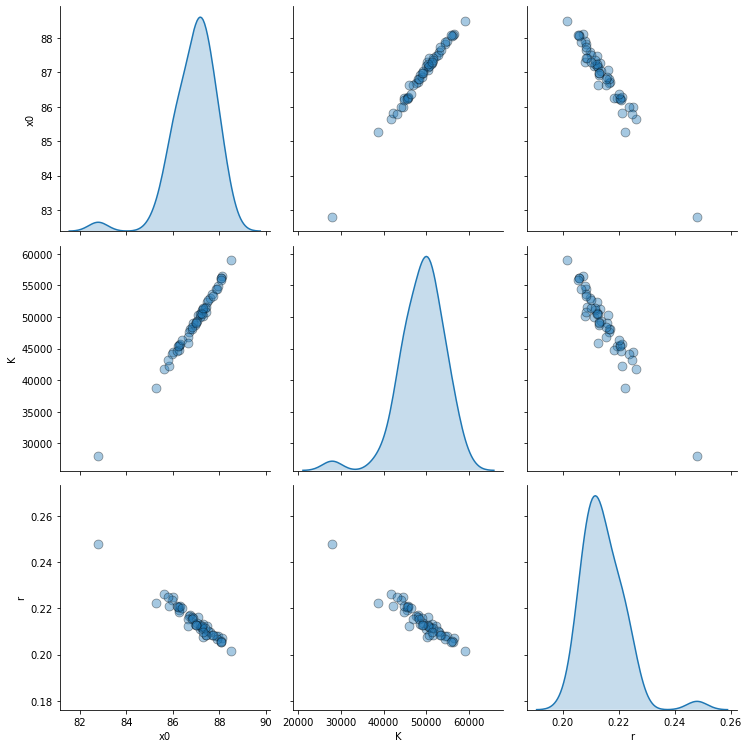

In [49]:
sigmodel.plot_params_distribution(height = 3.5, **{'alpha': 0.4, 's': 80, 'edgecolor': 'k'})
plt.tight_layout(h_pad=1.1)
plt.savefig("./img/pairplot-parameters.png", dpi=200, bbox_inches='tight')

In [ ]:
lockdown = {
    "China": pd.Timestamp("23/01/2020"),
    "Italy": pd.Timestamp("23/02/2020"),
    "South Korea": pd.Timestamp("23/02/2020"),
}

inflection = {
    "Italy": pd.Timestamp("16/03/2020"),
}

In [ ]:
lockdown["China"]

In [ ]:
df = get_country_and_min_count(data, "Italy")
df[df.date == lockdown["Italy"]]
df = df.reset_index()

In [ ]:
from sklearn.linear_model import LinearRegression as lr

def logit(x):
    return np.log(x/(1-x))

def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))

    
plt.figure(figsize=(14, 7))
plt.plot(t, df.total_cases, '.')
for K in range(50000, 100000, 5000):
    y = df.total_cases / K
    X = (df.index.values + 1).reshape(-1, 1)

    model = lr()
    model.fit(X, logit(y))

    print(f"r = {model.coef_[0]}")
    print(f"a = {np.exp(-model.intercept_)}")


    t_pred = np.arange(1, 100, 1)
    pred = inv_logit(model.predict(t_pred.reshape(-1, 1))) * K
    plt.plot(t_pred, pred)
plt.show()

In [ ]:
from scipy.optimize import minimize

y = df.total_cases 
t = (df.index.values + 1)
t_inflection = 28

# x = (x0, K, a, r)
fun = lambda x: np.mean( (y - sigmoid(t, *x))**2)
#fun = lambda x: np.mean( np.abs((y - sigmoid(t, *x))))

#cons = ({'type': 'eq', 'fun': lambda x : np.log(x[2]) / x[3] + x[0] - t_inflection})

#bnds = ((1, None), (max(y)*1.4, None), (0.01, None), (0.0001, None))

a0 = np.e
r0 = 0.1

x0 = (t_inflection - 10*np.e, max(y)*1.4, a0, r0)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, constraints=cons)
res = minimize(fun, x0, method='Nelder-Mead')
res